#### Import

In [2]:
import sys
sys.path.insert(0,'..')
import urx
import time
import math3d as m3d
ur = urx.Robot("192.168.1.10", use_rt=True)
pose = ur.get_pose()
print(pose)
from ddh import DDGripper
from scooping_primitives import HighSpeedScooping
from data_logger import DataLogger
from jupyterthemes import jtplot
white = 0
if white:
    jtplot.style(theme='default', figsize=(25, 8))
else:
    jtplot.style(figsize=(25, 8))

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


<Transform:
<Orientation: 
array([[ 4.03907226e-05,  8.66069110e-01, -4.99924290e-01],
       [ 9.99999997e-01, -3.88250587e-06,  7.40676235e-05],
       [ 6.22067217e-05, -4.99924292e-01, -8.66069107e-01]])>
<Vector: (-0.51184, 0.45005, 0.26942)>
>


In [3]:
gripper = DDGripper("ddh_scooping")
scoop = HighSpeedScooping(ur, gripper, "hss_card_fast")
logger = DataLogger(ur, gripper, scoop)

reading gripper config...
connecting to odrive...
found left finger
found right fingers
reading scooping config...


In [68]:
scoop.initialize_pose((-0.505,0.45,180))

Setting left tip: (131.4161234622261, 61.54052623496334)
Setting right tip: (100.44299589926962, 35.774736626568895)
Setting pose: 
[-0.5266      0.45        0.25       -1.8724501  -1.8724501   0.59038125]


Start logging
Collision detected!
Setting left tip: (155, 45)
Setting right tip: (155, -45)
Reached zero speed!


/home/john/high_speed_scooping/script/ddh.py:263: RuntimeWarning: invalid value encountered in sqrt
  distal_r = np.sqrt(self.geometry_l2**2 - (self.geometry_l1*np.sin(deg2rad(self.right_a2)))**2)


==========Scooping completed!==========
Speed at collision: -0.44189 m/s
Distance to decelerate: 0.06925 m
Deceleration for lifting: 4.88177 m/s^2
Slept time for lifting: 0.53 s
Lifted distance: 0.27534 m
Stop logging
Collision time: 1130 ms


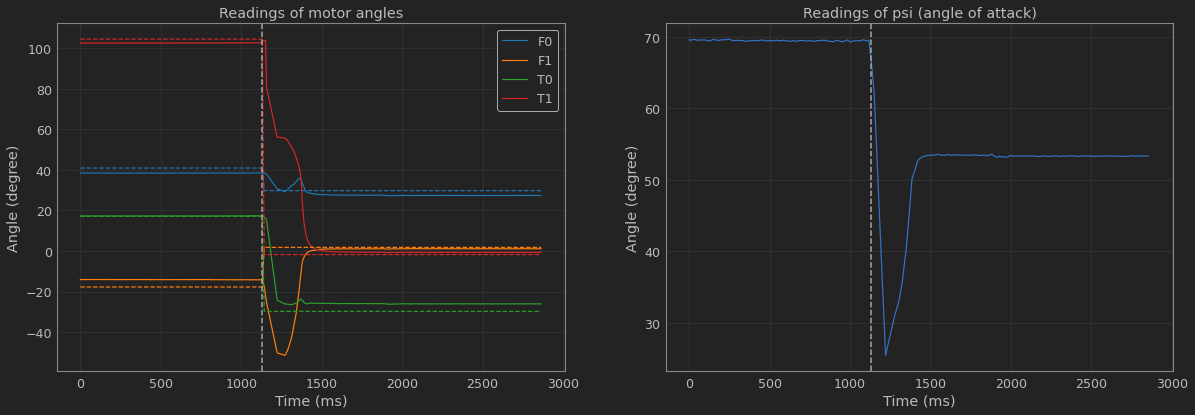

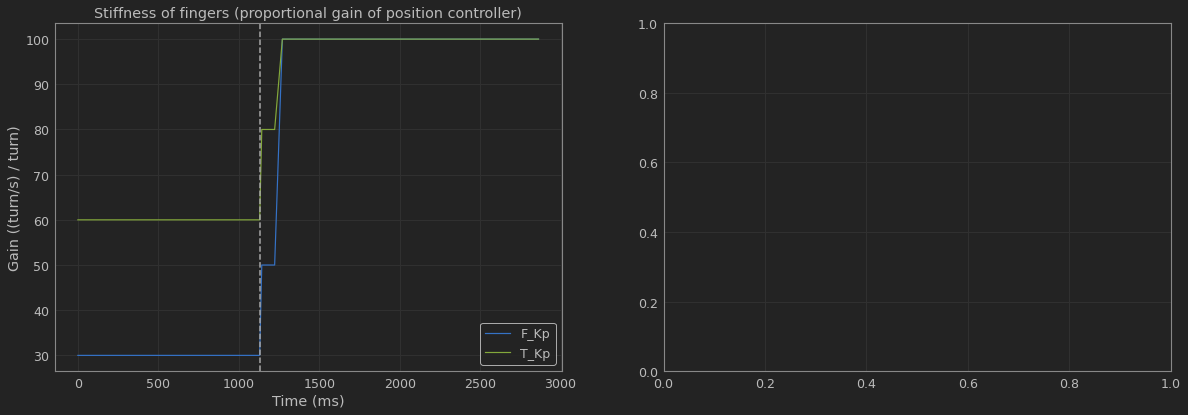

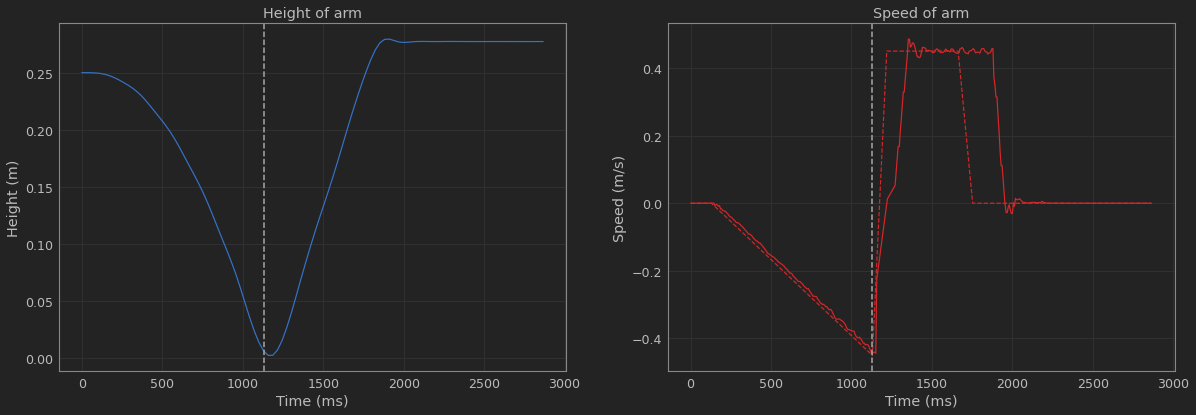

In [69]:
logger.logged = True
scoop.simple_scoop()
logger.logged = False
logger.plot_data(False)

#### Input Bandwidth Testing

In [56]:
gripper.set_left_tip((157, 40))
gripper.set_right_tip((157, -40))

Setting left tip: (157, 40)
Setting right tip: (157, -40)


Start logging
Setting left tip: (150, 0)
Setting right tip: (150, 0)
Stop logging


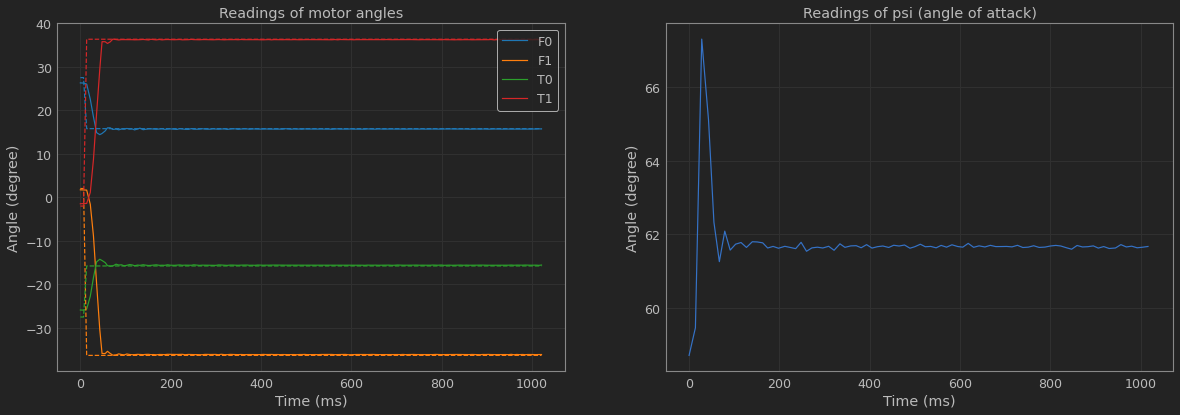

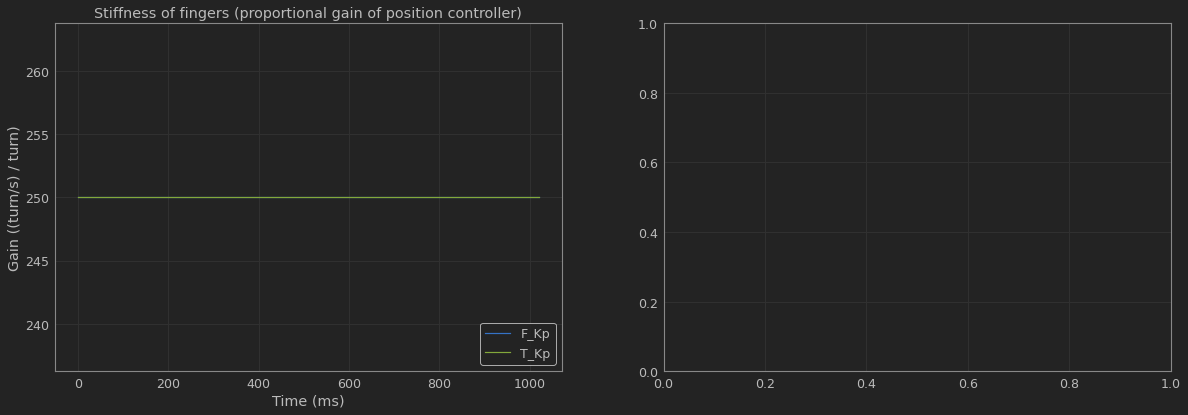

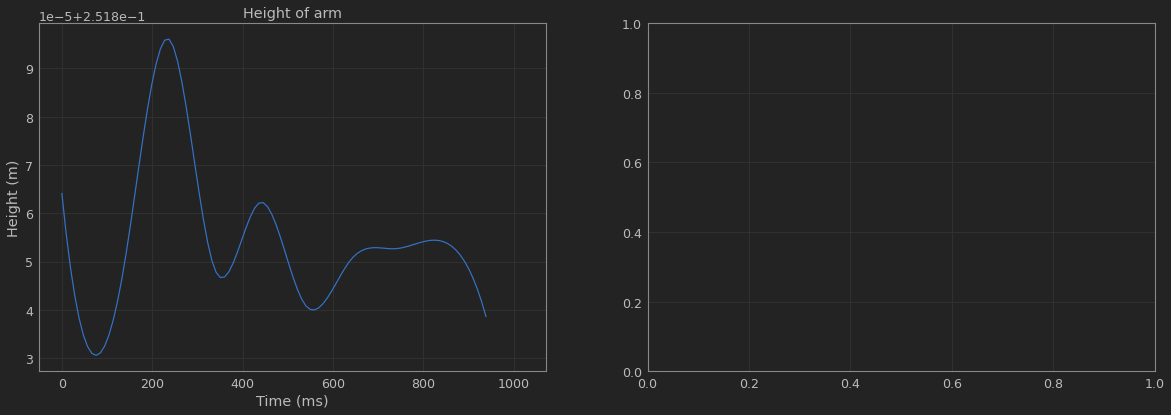

In [57]:
logger.logged = True
gripper.arm(BW=100)
gripper.set_left_tip((150,0))
gripper.set_right_tip((150,0))
time.sleep(1)
logger.logged = False
logger.plot_data(True)

#### script testing

In [ ]:
gripper.arm()
gripper.set_stiffness(20)
gripper.set_left_tip((158, 38))
gripper.set_right_tip((158, -38))
# gripper.set_parallel_jaw(-14.5, 0)

In [ ]:
gripper.arm(BW = 0.1)

In [ ]:
gripper.set_left_tip((140, 20))
gripper.set_right_tip((140, -20))

In [ ]:
gripper.set_left_tip((158, 38))
gripper.set_right_tip((158, -38))

#### deceleration control and end pos control

In [ ]:
ur.speedl([0.4,0,0,0,0,0],0.4,10)

In [ ]:
# print(ur.get_tcp_speed(wait=False)[0])
stop_dist = 0.05
end_dist = 0.3
reverse_vel = 0.4
spd_detect = ur.get_tcp_speed(wait=False)[0]
stop_dec = (spd_detect**2)/(2*stop_dist)
ur.speedl([-reverse_vel,0,0,0,0,0],stop_dec,10)
pos_dec = ur.getl()[0]
while ur.get_tcp_speed(wait=False)[0] > 0:
    continue
pos_stop = ur.getl()[0]
print("Reach zero vel!")
t_acc = reverse_vel / stop_dec
s_acc = 0.5 * stop_dec * t_acc**2
t_const = (end_dist-s_acc) / reverse_vel
print(s_acc)
print(t_acc+t_const)
time.sleep(t_acc+t_const)
ur.stopl(5)
pos_end = ur.getl()[0]

In [ ]:
ur.stopl(2)
stop_dist = pos_stop - pos_dec
reverse_dist = pos_end - pos_stop
print(spd_detect)
print(stop_dec)
print(stop_dist)
print(reverse_dist)

In [ ]:
pose = ur.get_pose()
print(pose)
print(ur.getl())

#### scooping test

In [ ]:
scoop.prescoop_initialize((-0.509,0.45,180))
time.sleep(0.5)
a2_init = gripper.right_a2

In [ ]:
# smack and scoop
smack_vel = 0.3 #100
smack_acc = 0.3 #0.3
stop_smack_acc = 3 #7
reverse_vel = 0.3 # 250
reverse_acc = 0.35 #1
stop_acc = 0.5 #0.5
stop_dist = 0.01

# robot accelerate
ur.speedl([0,0,-smack_vel,0,0,0],smack_acc,5)
# robot detect collision, then stop, close gripper, and go up
while 1:
    a2_cur = gripper.right_a2
    #print(a2_cur)
    if a2_cur - a2_init > 0.3:
        print ("Collision detected!")
        z_spd = ur.get_tcp_speed(wait=False)[2]
        stop_dec = (z_spd**2)/(2*stop_dist)
        gripper.set_stiffness(20, 'R')
#         gripper.set_left_tip((158, 38))
#         gripper.set_right_tip((158, -38))
        gripper.set_left_tip((157, 41))
        gripper.set_right_tip((157, -41))
#         ur.stopl(stop_smack_acc)
        gripper.set_stiffness(100)
        ur.speedl([0,0,reverse_vel,0,0,0],stop_smack_acc,5)
        time.sleep(0.2)
        ur.stopl(stop_acc)
        break

In [ ]:
print(z_spd)
print(stop_dec)

In [ ]:
gripper.set_left_tip((157, 41))
gripper.set_right_tip((157, -41))

In [ ]:
ur.stopl()